In [1]:
import os
import seaborn
import cv2 as cv
import numpy as np
import tensorflow as tf
from sklearn import metrics
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm

from tensorflow.keras import models, layers, losses, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.random.set_seed(777)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
train_generator = ImageDataGenerator(rescale=1/255.)
valid_generator = ImageDataGenerator(rescale=1/255.)

IMG_SIZE = 224

train_loader = train_generator.flow_from_directory('./data/Train', target_size=(IMG_SIZE,IMG_SIZE), 
                                                 classes=['etc', 'chalcopyrite'],
                                                 class_mode='binary', 
                                                )
print(f"학습용 황동석 이미지 수: {(train_loader.labels==1).sum()}")
print(f"학습용 황동석 아닌 이미지 수: {(train_loader.labels==0).sum()}\n")

valid_loader = valid_generator.flow_from_directory('./data/Test', target_size=(IMG_SIZE,IMG_SIZE), 
                                                 classes=['etc', 'chalcopyrite'],
                                                 class_mode='binary'
                                                )
print(f"검증용 황동석 이미지 수: {(valid_loader.labels==1).sum()}")
print(f"검증용 황동석 아닌 이미지 수: {(valid_loader.labels==0).sum()}")

Found 1657 images belonging to 2 classes.
학습용 황동석 이미지 수: 712
학습용 황동석 아닌 이미지 수: 945

Found 184 images belonging to 2 classes.
검증용 황동석 이미지 수: 79
검증용 황동석 아닌 이미지 수: 105


### Load model

In [3]:
model_name = 'mobilenet'
model = models.load_model(f'./checkpoints/{model_name}.h5')

### Evaluate model

In [4]:
train_infer = model.predict(train_loader, verbose=1)
valid_infer = model.predict(valid_loader, verbose=1)

6/6 [==============================] - 1s 118ms/step


### Plot evaluation result

In [5]:
threshold = 0.5

train_infer = np.greater_equal(train_infer[:, 0], threshold).astype(np.int32)
valid_infer = np.greater_equal(valid_infer[:, 0], threshold).astype(np.int32)

train_cf = metrics.confusion_matrix(train_loader.labels, train_infer)
valid_cf = metrics.confusion_matrix(valid_loader.labels, valid_infer)

In [6]:
def plot_confusion_matrix(data, labels):

    seaborn.set(color_codes=True)
 
    plt.title("Confusion Matrix")
 
    seaborn.set(font_scale=1)
    ax = seaborn.heatmap(data, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Scale'})
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")

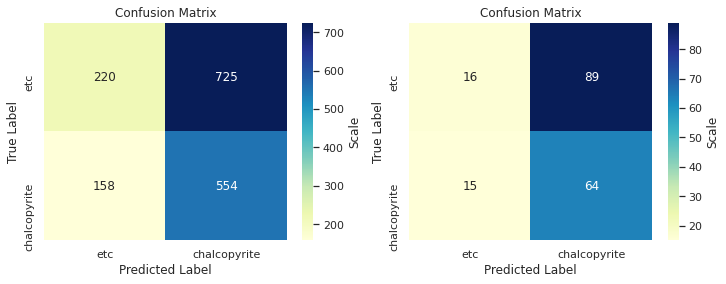

In [8]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_confusion_matrix(train_cf, ['etc', 'chalcopyrite'])

plt.subplot(1, 2, 2)
plot_confusion_matrix(valid_cf, ['etc', 'chalcopyrite'])

plt.savefig(f"./figures/{model_name}_confusion_matrix.jpg")
plt.show()